In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

# Load spam data

In [2]:
feature_list = []
with open('data/spambase.names') as f:
    line = f.readline()
    while (len(line)>0):
        line = f.readline()
        if (not line.startswith(('|','\n',' ','1','\n'))) and (line.find(':')>0):
            feature_list.append(line[:line.find(':')])

In [3]:
len(feature_list)

57

In [4]:
df = pd.read_csv('data/spambase.data',sep=',', header=None, names=feature_list+['is_spam'])

In [5]:
df.describe()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,is_spam
count,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,...,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000
mean,0.104553,0.213015,0.280656,0.065425,0.312223,0.095901,0.114208,0.105295,0.090067,0.239413,...,0.038575,0.139030,0.016976,0.269071,0.075811,0.044238,5.191515,52.172789,283.289285,0.394045
std,0.305358,1.290575,0.504143,1.395151,0.672513,0.273824,0.391441,0.401071,0.278616,0.644755,...,0.243471,0.270355,0.109394,0.815672,0.245882,0.429342,31.729449,194.891310,606.347851,0.488698
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.588000,6.000000,35.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.065000,0.000000,0.000000,0.000000,0.000000,2.276000,15.000000,95.000000,0.000000
75%,0.000000,0.000000,0.420000,0.000000,0.380000,0.000000,0.000000,0.000000,0.000000,0.160000,...,0.000000,0.188000,0.000000,0.315000,0.052000,0.000000,3.706000,43.000000,266.000000,1.000000
max,4.540000,14.280000,5.100000,42.810000,10.000000,5.880000,7.270000,11.110000,5.260000,18.180000,...,4.385000,9.752000,4.081000,32.478000,6.003000,19.829000,1102.500000,9989.000000,15841.000000,1.000000


## Split data to train vs test

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
X = np.array(df[feature_list])
y = np.array(df['is_spam'])

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=41235)

In [10]:
X_train_log = np.log(X_train+0.1)
X_test_log = np.log(X_test+0.1)

# Logistic regression

In [11]:
from sklearn.linear_model import LogisticRegression

In [14]:
logreg = LogisticRegression().fit(X_train_log, y_train)

/Users/yuchenj/learn/playground/env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [15]:
# Test Error rate
y_hat = logreg.predict(X_test_log)
(y_hat!=y_test).mean()

0.05793285055957867

In [22]:
def get_error_rate(y_predict, y):
    df_res = pd.DataFrame(np.array([y_predict,y_test]).T, columns=['y_predict','y'])
    return df_res.groupby(['y_predict','y']).apply(lambda x: x.index.nunique()/len(df_res)).unstack(1)

In [23]:
get_error_rate(y_hat, y)

y,0,1
y_predict,,
0,0.600395,0.031600
1,0.026333,0.341672


In [24]:
# Weighted loss, less tolerant on misclassify an email to spam (low Type-2 error rate, or False Negative rate.)
logreg = LogisticRegression(class_weight={0:5,1:1}).fit(X_train_log, y_train)

/Users/yuchenj/learn/playground/env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [25]:
# Test Error rate
y_hat = logreg.predict(X_test_log)
(y_hat!=y_test).mean()

0.07834101382488479

In [26]:
get_error_rate(y_hat, y)

y,0,1
y_predict,,
0,0.615537,0.067149
1,0.011192,0.306122


In [63]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(criterion='entropy', ccp_alpha=0.05)
clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.05, criterion='entropy')

In [64]:
p_hat = 1246.0/3082
p_hat = 87.0/774
-np.log2(p_hat)*p_hat - (1-p_hat)*np.log2(1-p_hat)

0.5071221533577512

In [65]:
import graphviz
data = tree.export_graphviz(clf, out_file=None, feature_names= feature_list, class_names=['email','spam'],filled=True, rounded=True, special_characters=True)
graph = graphviz.Source(data) 

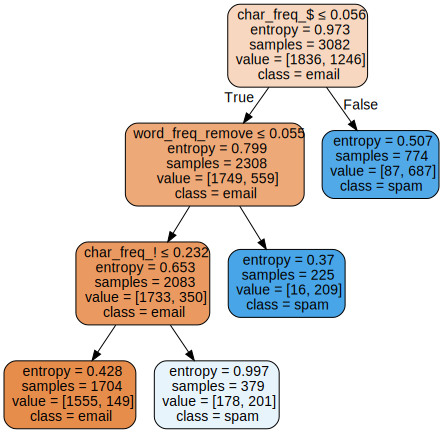

In [66]:
graph

In [67]:
from IPython.display import SVG
from IPython.display import display
from sklearn import tree

In [69]:
def plot_tree(criterion, max_leaf_nodes):
    
    clf = tree.DecisionTreeClassifier(criterion=criterion, max_leaf_nodes=max_leaf_nodes)
    clf.fit(X_train, y_train)
    
    graph = graphviz.Source(tree.export_graphviz(clf, 
                                                 out_file=None, 
                                                 feature_names= feature_list, 
                                                 class_names=['email','spam'],
                                                 filled=True, 
                                                 rounded=True, 
                                                 special_characters=True)) 
    display(SVG(graph.pipe(format='svg')))
    
    return clf

In [74]:
from ipywidgets import interactive

inter=interactive(plot_tree 
                  , criterion = ["gini", "entropy"]
                  , max_leaf_nodes=[i for i in range(2,21)])

In [75]:
inter

interactive(children=(Dropdown(description='criterion', options=('gini', 'entropy'), value='gini'), Dropdown(d…

In [231]:
from IPython.display import display
def f(a, b):
    display(a + b)
    return a+b

w = interactive(f, a=10, b=20)

In [232]:
display(w)

30

In [14]:
len(X_train)

3082

In [15]:
len(X_test)

1519

In [6]:
1536.0/(1536+3065)

0.3338404694631602

In [16]:
import pandas as pd        
from pygam import LogisticGAM

In [17]:
LogisticGAM()

Init signature:
LogisticGAM(
    terms='auto',
    max_iter=100,
    tol=0.0001,
    callbacks=['deviance', 'diffs', 'accuracy'],
    fit_intercept=True,
    verbose=False,
    **kwargs,
)
Docstring:     
Logistic GAM

This is a GAM with a Binomial error distribution, and a logit link.

Parameters
----------
terms : expression specifying terms to model, optional.

    By default a univariate spline term will be allocated for each feature.

    For example:

    >>> GAM(s(0) + l(1) + f(2) + te(3, 4))

    will fit a spline term on feature 0, a linear term on feature 1,
    a factor term on feature 2, and a tensor term on features 3 and 4.

callbacks : list of str or list of CallBack objects, optional
    Names of callback objects to call during the optimization loop.

fit_intercept : bool, optional
    Specifies if a constant (a.k.a. bias or intercept) should be
    added to the decision function.
    Note: the intercept receives no smoothing penalty.

max_iter : int, optional
    Maxim

In [34]:
import pandas as pd        
from pygam import LogisticGAM, GAM, l, s, f
from sklearn.datasets import load_breast_cancer
#load the breast cancer data set
data = load_breast_cancer()
#keep first 6 features only
df = pd.DataFrame(data.data, columns=data.feature_names)[['mean radius', 'mean texture', 'mean perimeter', 'mean area','mean smoothness', 'mean compactness']]
target_df = pd.Series(data.target)
df.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400


In [59]:
X = df[['mean radius', 'mean texture', 'mean perimeter', 'mean area','mean smoothness', 'mean compactness']]
y = target_df
#Fit a model with the default parameters
gam = LogisticGAM(l(0)+l(1)+l(2)+l(3)+l(4)+l(5)).fit(X, y)

In [60]:
gam.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      4.4857
Link Function:                        LogitLink Log Likelihood:                                   -110.929
Number of Samples:                          569 AIC:                                              230.8293
                                                AICc:                                             230.9558
                                                UBRE:                                                2.412
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.7048
Feature Function                  Lam

/Users/yuchenj/learn/playground/env/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  """Entry point for launching an IPython kernel.


In [61]:
gam.accuracy(X, y)

0.9138840070298769

In [63]:
gam.coef_

array([ 3.82448051e+00, -2.25317749e-01, -7.18556925e-01, -8.49193383e-04,
       -7.83779522e-01, -1.19868359e+00,  1.77725470e+01])

In [64]:
from sklearn.linear_model import LogisticRegression

In [73]:
lgreg = LogisticRegression().fit(X,y)

/Users/yuchenj/learn/playground/env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [74]:
lgreg.coef_

array([[ 2.93218947, -0.22367123, -0.65404897,  0.0040385 , -0.50285347,
        -0.82435899]])

In [67]:
LogisticRegression?

Init signature:
LogisticRegression(
    penalty='l2',
    *,
    dual=False,
    tol=0.0001,
    C=1.0,
    fit_intercept=True,
    intercept_scaling=1,
    class_weight=None,
    random_state=None,
    solver='lbfgs',
    max_iter=100,
    multi_class='auto',
    verbose=0,
    warm_start=False,
    n_jobs=None,
    l1_ratio=None,
)
Docstring:     
Logistic Regression (aka logit, MaxEnt) classifier.

In the multiclass case, the training algorithm uses the one-vs-rest (OvR)
scheme if the 'multi_class' option is set to 'ovr', and uses the
cross-entropy loss if the 'multi_class' option is set to 'multinomial'.
(Currently the 'multinomial' option is supported only by the 'lbfgs',
'sag', 'saga' and 'newton-cg' solvers.)

This class implements regularized logistic regression using the
'liblinear' library, 'newton-cg', 'sag', 'saga' and 'lbfgs' solvers. **Note
that regularization is applied by default**. It can handle both dense
and sparse input. Use C-ordered arrays or CSR matrices containi